In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order


Data prep

In [2]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

In [3]:
#load data here 
data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251107_seaad\M_classifier'
os.makedirs(out_dir, exist_ok=True)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_layer_dict.json", "r") as f:
    ttype_to_layer_dict = json.load(f)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L23_ttype_rename.json", "r") as f:
    L23_ttype_rename_dict = json.load(f)

#load the data
metadata = pd.read_csv(os.path.join(data_root, 'metadata.csv'))
metadata = metadata.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata = metadata[['specimen_id', 't_type', 'subclass_label']]
metadata.subclass_label = metadata.subclass_label.str.replace('L5 ET_ME', 'L5 ET')
metadata.t_type = metadata.t_type.str.replace('L5 ET_ME', 'L5 ET(ME)')
metadata.t_type = metadata.t_type.apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata['layer'] = metadata["t_type"].map(ttype_to_layer_dict)

#split Layer 2 and 3 subclass
metadata["layer_subclass"] = metadata.apply(
    lambda row: "L2 IT" if row["layer"] == 'Layer 2'
                else ("L3 IT" if row["layer"] == 'Layer 3'
                    else row["subclass_label"]),
    axis=1
) 
metadata['specimen_id'] = metadata['specimen_id'].astype('int')
metadata = metadata.set_index('specimen_id')

#get transcriptomic order (from RD - mostly trying to keep ttypes ordered by depth within subclasses)
ttype_order, subclass_order = get_tx_order()
layer_subclass_order = ['L2 IT'] + [l.replace('L2/3 IT', 'L3 IT') for l in subclass_order]

#get seaad colors 
color_dict = get_seaad_colors()

#get tx order
label_order = {
    'subclass_label' : subclass_order,
    'layer_subclass' : layer_subclass_order, 
    't_type' : ttype_order
}

# # sparce pca alpha = 9, 52
# features_spca = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\M_classifier\sparse_pca\M_dendrite_spca_alpha_14_ncomps_52_transformedValues.csv', index_col='specimen_id')

#raw features (cells without apicals have these nans filled to zeros)
# features_filled = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\M_classifier\filled_features\M_dendrite_features_filled.csv', index_col='specimen_id')
features_filled = pd.read_csv(os.path.join(data_root, 'RawFeatureWide_imputed.csv'), index_col='specimen_id')

features_filled

,apical_dendrite_bias_x,apical_dendrite_bias_y,apical_dendrite_depth_pc_0,apical_dendrite_depth_pc_1,apical_dendrite_depth_pc_2,apical_dendrite_depth_pc_3,apical_dendrite_depth_pc_4,apical_dendrite_early_branch_path,apical_dendrite_emd_with_basal_dendrite,apical_dendrite_extent_x,...,basal_dendrite_num_branches,basal_dendrite_soma_percentile_x,basal_dendrite_soma_percentile_y,basal_dendrite_stem_exit_down,basal_dendrite_stem_exit_side,basal_dendrite_stem_exit_up,basal_dendrite_total_length,basal_dendrite_total_surface_area,soma_aligned_dist_from_pia,soma_surface_area
specimen_id,,,,,,,,,,,,,,,,,,,,,
539733464,53.540468,468.177319,362.804482,-74.186158,93.085425,2.615318,111.300186,0.739122,32.116647,379.760227,...,46.0,0.467771,0.839503,0.0,0.833333,0.166667,5576.457694,18580.476438,299.500548,4164.739934
539736965,176.912475,609.923926,405.620349,-17.286912,52.017317,66.759770,28.415064,0.866055,57.630926,500.136235,...,41.0,0.387177,0.915693,0.0,0.714286,0.285714,3885.836213,9057.621410,462.465669,1389.976460
539736968,77.127287,318.175758,278.014860,-78.894277,93.511048,28.247878,103.713015,0.785347,25.667854,426.013061,...,20.0,0.479722,0.851101,0.0,1.000000,0.000000,2214.071354,6138.071491,251.953266,860.332706
541549258,104.777742,537.879061,200.766403,-34.537899,20.991138,-22.514555,-5.921573,0.646795,48.477689,394.690478,...,48.0,0.496624,0.744186,0.0,1.000000,0.000000,4086.411006,5066.517201,449.778445,1197.425296
541557114,34.648411,448.495796,308.523362,-2.464016,2.939089,10.283975,-27.423948,0.788768,42.097325,338.680028,...,63.0,0.404688,0.693056,0.0,1.000000,0.000000,6128.616683,19277.681252,450.093258,1308.879458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324757669,46.238201,950.134478,-74.530447,551.450902,-101.127102,45.564391,418.485349,0.329146,80.810104,421.573696,...,96.0,0.430282,0.978975,0.0,0.875000,0.125000,9042.471722,18319.487504,1117.195290,1932.295772
1325022545,31.065345,820.325032,134.147686,62.898224,-61.710510,16.496499,-2.907086,0.741354,92.443764,212.625875,...,73.0,0.482322,0.818420,0.0,1.000000,0.000000,4060.325512,8459.406721,865.209652,344.243153
1325022560,210.064390,1374.165654,-119.931542,-68.218037,49.137065,223.554145,-46.684712,0.268587,100.303993,360.185028,...,25.0,0.122542,0.904435,0.0,1.000000,0.000000,3259.659819,6720.310964,1849.992988,1023.190826


In [4]:
#Remove the one von economo neuron
ven_spid = 1263702688
metadata = metadata.drop(index=ven_spid, errors='ignore')
features_filled = features_filled.drop(index=ven_spid, errors='ignore')

In [5]:
#only keep the cells that have both M and E (and Von Econimo cell removed)
ME_cells = pd.read_csv(os.path.join(out_dir.replace('M_classifier', 'ME_classifier'), 'ME_classifier_cells.csv'))

me_filter = False #whether to filter the data to just cells that have M and E data

if me_filter: 
    metadata = metadata[metadata.index.isin(ME_cells.specimen_id.tolist())]
    features_filled = features_filled[features_filled.index.isin(ME_cells.specimen_id.tolist())]

RF params

In [6]:
feature_type = 'rawFeatures' #'rawFeatures', 'sparcePCA
label_columns = ['t_type', 'subclass_label', 'layer_subclass', 'layer']

depth_types = ['withDepth', 'withoutDepth']

min_num_cells = 4 #5 #8 #20 #12 #15 #10 #min num cells per group (in label) columns

num_cell_xbuffer = {'subclass_label':0.3,
                    'layer_subclass':0.3,
                    'layer':0.3,
                    't_type': 0.5}

fig_sizes = {'subclass_label': (6, 6),
             'layer_subclass': (6, 6),
             'layer': (6, 6),
             't_type': (9,9)}

n_height = {'subclass_label' : 0.015, 
            'layer_subclass' : 0.015, 
            'layer' : 0.015, 
             't_type' : -0.06}

label_order['layer'] = ['Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6']

Loop through label predictions

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
CV (n=3 folds) | Accuracy: 0.528 ± 0.003 | F1 (weighted): 0.485 ± 0.013


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

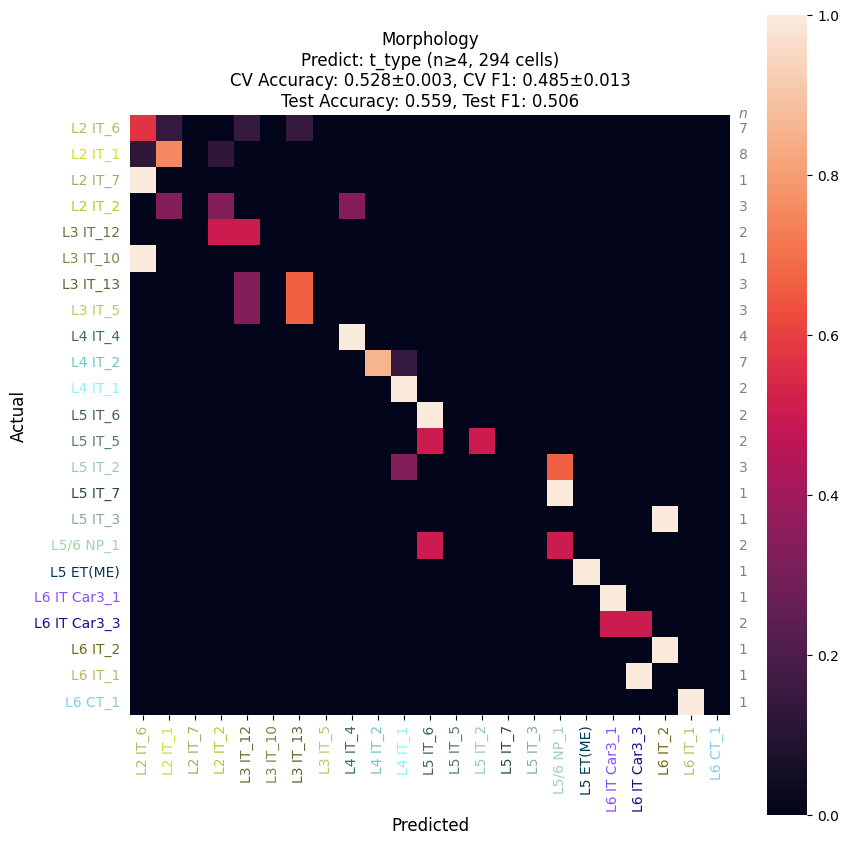

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
CV (n=3 folds) | Accuracy: 0.823 ± 0.010 | F1 (weighted): 0.811 ± 0.009


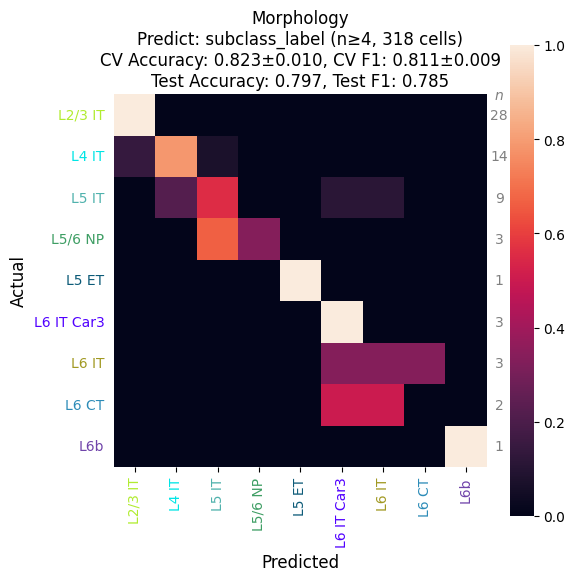

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
CV (n=3 folds) | Accuracy: 0.807 ± 0.040 | F1 (weighted): 0.799 ± 0.039


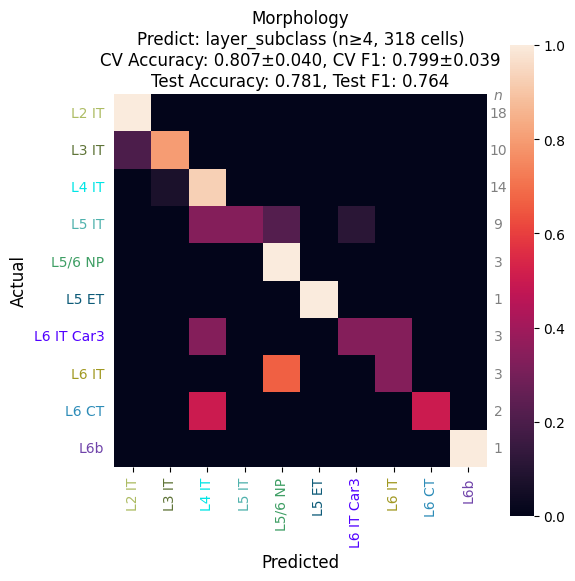

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
CV (n=3 folds) | Accuracy: 0.866 ± 0.024 | F1 (weighted): 0.865 ± 0.023


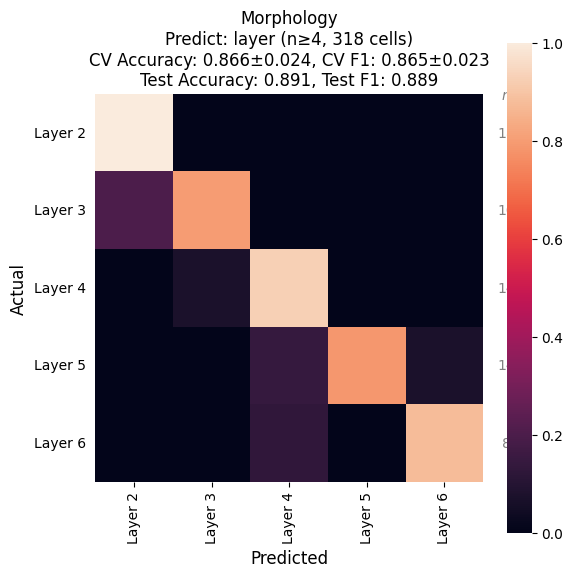

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
CV (n=3 folds) | Accuracy: 0.519 ± 0.023 | F1 (weighted): 0.480 ± 0.017


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

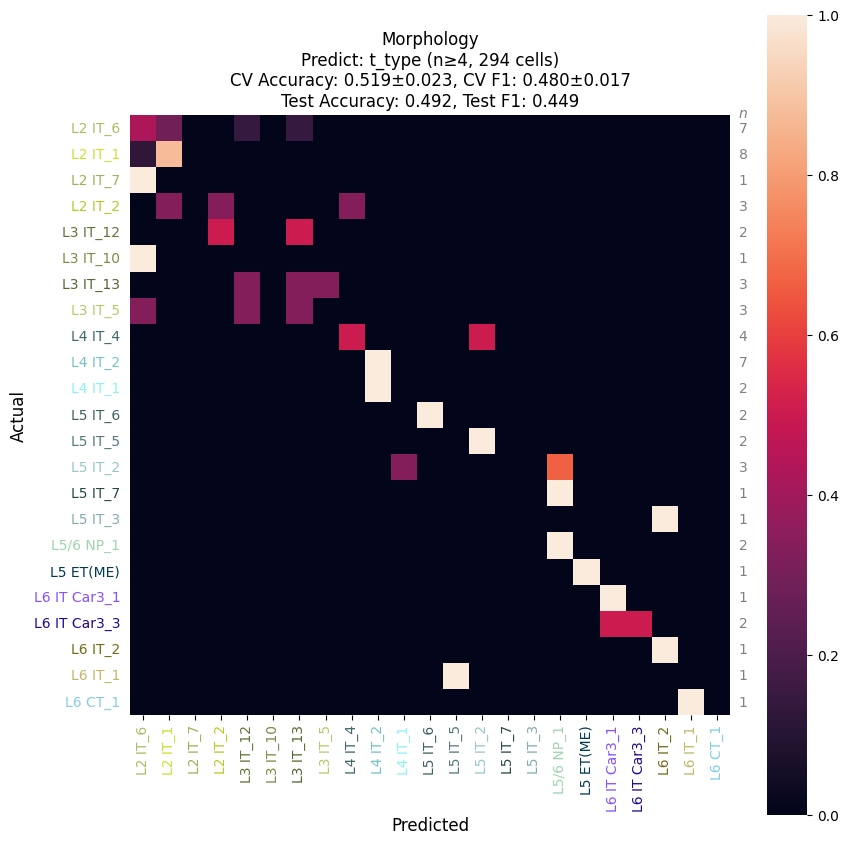

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
CV (n=3 folds) | Accuracy: 0.799 ± 0.016 | F1 (weighted): 0.792 ± 0.019


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

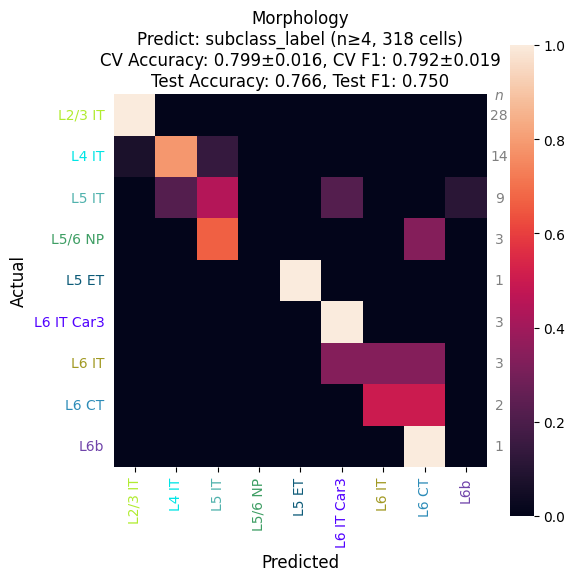

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
CV (n=3 folds) | Accuracy: 0.783 ± 0.051 | F1 (weighted): 0.778 ± 0.048


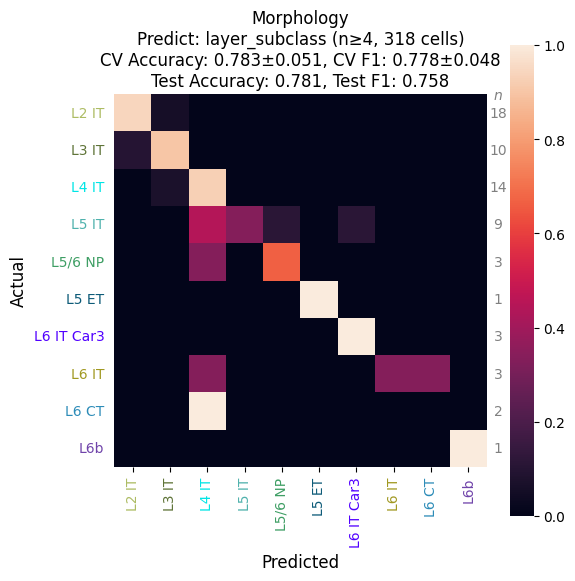

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
CV (n=3 folds) | Accuracy: 0.851 ± 0.048 | F1 (weighted): 0.850 ± 0.048


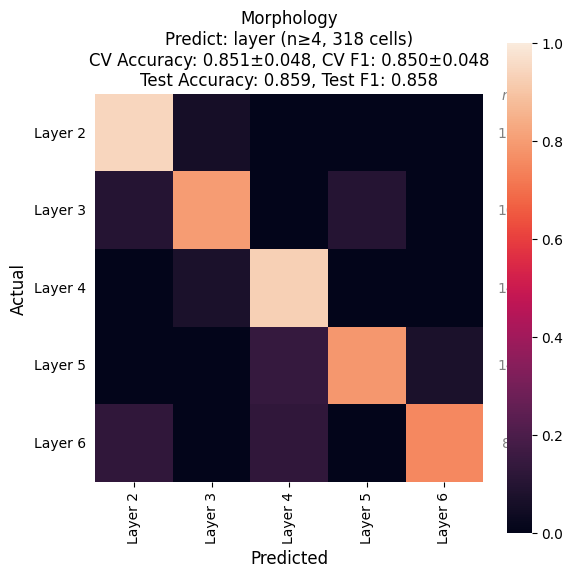

In [7]:
for depth_type in depth_types:
    fig_path = os.path.join(out_dir, 'human_excitatory_morpho_classifier_rf_min_{}_cells_{}_{}.pdf'.format(min_num_cells, feature_type, depth_type))
    if me_filter: fig_path = fig_path.replace('.pdf', '_meFilter.pdf')
    with PdfPages(fig_path) as pdf:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)


        for label_column in label_columns:

            # if feature_type == 'rawFeatures':
            data = features_filled
            # elif feature_type == 'sparcePCA':
            #     data = features_spca
            # else:
            #     ValueError('feature type not recognized!')

            #filter out data with a nan label_column value
            this_metadata = metadata.dropna(subset=label_column)

            feature_columns = data.columns.tolist()
            if depth_type == 'withoutDepth':
                feature_columns.remove('soma_aligned_dist_from_pia')

            id_column = 'specimen_id'
            data = data.merge(this_metadata, how='inner', left_index=True, right_index=True)
            labels = sorted(data[label_column].unique())

            #filter out data in [ttype] with less than n cells
            label_counts = data[label_column].value_counts()
            labels = sorted(label_counts[label_counts >= min_num_cells].index)
            labels = [l for l in label_order[label_column] if l in labels]
            data = data[data[label_column].isin(labels)]

            num_cells_total = len(data)

            #80/20 : train/test
            y = data[label_column]
            X = data[feature_columns]
            X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, data.index, stratify=y, train_size=0.8, random_state=42)  #80/20 : train/test

            #normalize data
            scaler = StandardScaler() 
            X_train = scaler.fit_transform(X_train) 
            X_test = scaler.transform(X_test)

            #stratified kfold cross validation 
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            #make model 
            rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

            # Hyperparameters to search
            param_grid = {
                'n_estimators': [50, 100, 150],  
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }

            # Perform grid search
            # grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, verbose=1, n_jobs=-1)
            scoring = {
                'accuracy': 'accuracy',
                'f1_weighted': 'f1_weighted'
            }

            grid_search = GridSearchCV(
                rf_classifier,
                param_grid,
                cv=cv,
                scoring=scoring,
                refit='f1_weighted',   # important
                verbose=1,
                n_jobs=-1,
                return_train_score=False
            )

            grid_search.fit(X_train, y_train)

            # Get the best model
            best_model = grid_search.best_estimator_
            print("Best Parameters:", grid_search.best_params_)

            cv_results = grid_search.cv_results_
            best_idx = grid_search.best_index_

            cv_acc_mean = cv_results['mean_test_accuracy'][best_idx]
            cv_acc_std  = cv_results['std_test_accuracy'][best_idx]

            cv_f1_mean  = cv_results['mean_test_f1_weighted'][best_idx]
            cv_f1_std   = cv_results['std_test_f1_weighted'][best_idx]

            print(
                f"CV (n={cv.get_n_splits()} folds) | "
                f"Accuracy: {cv_acc_mean:.3f} ± {cv_acc_std:.3f} | "
                f"F1 (weighted): {cv_f1_mean:.3f} ± {cv_f1_std:.3f}"
            )

            #test
            y_pred = best_model.predict(X_test)

            #evaluate
            target_names = [l for l in labels if l in sorted(set(y_test))]
            report = classification_report(y_test, y_pred, target_names=target_names)
            accuracy = accuracy_score(y_test, y_pred)
            f1_test = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred, labels=labels)
            true_label_counts = np.sum(cm, axis=1)
            normalized_cm = cm / true_label_counts[:, np.newaxis]

            #PLOT
            fig, ax = plt.subplots(ncols=1, nrows=1, figsize=fig_sizes[label_column])

            formatted_labels = labels # [l[3:].replace('_', ' ') if l.startswith('Exc ') else l.replace('_', ' ') for l in labels]
            sns.heatmap(normalized_cm, annot=False, fmt=".2f", cmap="rocket", vmin=0, vmax=1, xticklabels=formatted_labels, yticklabels=formatted_labels, square=True, cbar=True)

            plt.xlabel('Predicted', fontsize=12)
            plt.ylabel('Actual', fontsize=12)
            plt.title('Morphology\nPredict: ' + label_column + r" (n$\geq${}) ({} cells)".format(min_num_cells, num_cells_total) + '\nAccuracy: ' + str(round(accuracy,3)) + '\nF1 score: ' + str(round(f1_test,3)), fontsize=12)
            plt.title(
                'Morphology\n'
                f'Predict: {label_column} (n≥{min_num_cells}, {num_cells_total} cells)\n'
                f'CV Accuracy: {cv_acc_mean:.3f}±{cv_acc_std:.3f}, '
                f'CV F1: {cv_f1_mean:.3f}±{cv_f1_std:.3f}\n'
                f'Test Accuracy: {accuracy:.3f}, Test F1: {f1_test:.3f}',
                fontsize=12
            )
            plt.xticks(fontsize=10, rotation=90)  
            plt.yticks(fontsize=10, rotation=-0) 

            # Annotating counts on the right side
            for i in range(len(formatted_labels)):
                ax.text(len(formatted_labels)+num_cell_xbuffer[label_column], i + 0.5 , int(true_label_counts[i]), ha="center", va="center", fontsize=10, color='grey')
            ax.text(len(formatted_labels)+num_cell_xbuffer[label_column], n_height[label_column] , 'n', ha="center", va="center", fontsize=10, color='grey', fontstyle='italic')

            # Removing the axis on the count side
            ax.tick_params(axis='y', which='both', left=False, right=False)

            if 'cluster' in label_column:
                #plot lines to seperate subclasses
                for i, l in enumerate(labels):
                    subclass = metadata[metadata[label_column] == l][label_column.replace('cluster', 'subclass')].unique()[0]
                    if i > 0:
                        if last_subclass != subclass:
                            ax.hlines(i, *ax.get_xlim(), color='white', linewidth=1)
                            ax.vlines(i, *ax.get_ylim(), color='white', linewidth=1)
                    last_subclass = subclass

            # Setting different colors for x and y tick labels
            for label in ax.get_xticklabels():  
                text = label.get_text()
                # text = '_'.join(text.rsplit(' ', 1))
                try: 
                    label.set_color(color_dict[text])
                except: 
                    continue
            for label in ax.get_yticklabels(): 
                text = label.get_text()
                # text = '_'.join(text.rsplit(' ', 1)) 
                try: 
                    label.set_color(color_dict[text])
                except: 
                    continue

            plt.tight_layout()
            pdf.savefig(fig, bbox_inches='tight')
            plt.show()


Restrict to comparisons within layer --> predict supertype

In [9]:
feature_type = 'rawFeatures' #'rawFeatures', 'sparcePCA
group_column = 'layer'
label_columns = ['t_type', 'subclass_label']

min_num_cells = 3 #20 #12 #15 #10 #min num cells per group (in label) columns

num_cell_xbuffer = {group_column:0.3}

fig_sizes = {group_column: (6, 6)}

n_height = {group_column : 0.015}

groups = sorted(metadata[group_column].unique().tolist())
groups

['Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6']

['L5 IT_6', 'L5 IT_5', 'L5 IT_2', 'L5 IT_7', 'L5 IT_3', 'L5/6 NP_1', 'L5 ET_2', 'L5 ET(ME)']
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

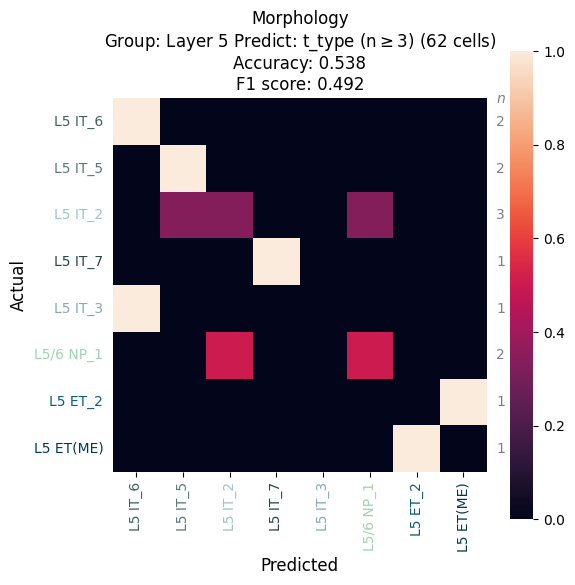

In [10]:
for depth_type in ['withDepth']: #depth_types:

    fig_path = os.path.join(out_dir, 'human_excitatory_morpho_classifier_rf_min_{}_cells_{}_group_{}_{}.pdf'.format(min_num_cells, feature_type, group_column, depth_type))
    if me_filter: fig_path = fig_path.replace('.pdf', '_meFilter.pdf')
    with PdfPages(fig_path) as pdf:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)

        for group in ['Layer 5']: #groups:

            for label_column in ['t_type']: #label_columns:

                # if feature_type == 'rawFeatures':
                data = features_filled
                # elif feature_type == 'sparcePCA':
                #     data = features_spca
                # else:
                #     ValueError('feature type not recognized!')

                #select group data and filter out data with a nan label_column value
                this_metadata = metadata[metadata[group_column] == group].dropna(subset=label_column)

                feature_columns = data.columns.tolist()
                if depth_type == 'withoutDepth':
                    feature_columns.remove('soma_aligned_dist_from_pia')
                    
                id_column = 'specimen_id'
                data = data.merge(this_metadata, how='inner', left_index=True, right_index=True)
                labels = sorted(data[label_column].unique())

                #filter out data in [ttype] with less than n cells
                label_counts = data[label_column].value_counts()
                labels = sorted(label_counts[label_counts >= min_num_cells].index)
                labels = [l for l in label_order[label_column] if l in labels]
                data = data[data[label_column].isin(labels)]
                print(labels)

                #make sure there are at least two label_column values left in data
                if len(this_metadata[this_metadata.index.isin(data.index.tolist())][label_column].unique()) < 2: 
                    print(f"Removing {label_column} gropus with fewer than {min_num_cells} cells left less than 2 types to predict. Skipping this group {group}.")
                    continue

                num_cells_total = len(data)

                #80/20 : train/test
                y = data[label_column]
                X = data[feature_columns]
                X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, data.index, stratify=y, train_size=0.8, random_state=42)  #80/20 : train/test

                #normalize data
                scaler = StandardScaler() 
                X_train = scaler.fit_transform(X_train) 
                X_test = scaler.transform(X_test)

                #stratified kfold cross validation 
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                #make model 
                rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

                # Hyperparameters to search
                param_grid = {
                    'n_estimators': [50, 100, 150],  
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }

                # Perform grid search
                grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, verbose=1, n_jobs=-1)
                grid_search.fit(X_train, y_train)

                # Get the best model
                best_model = grid_search.best_estimator_
                print("Best Parameters:", grid_search.best_params_)

                #test
                y_pred = best_model.predict(X_test)

                #evaluate
                target_names = [l for l in labels if l in sorted(set(y_test))]
                report = classification_report(y_test, y_pred, target_names=target_names)
                accuracy = accuracy_score(y_test, y_pred)
                f1_test = f1_score(y_test, y_pred, average='weighted')
                cm = confusion_matrix(y_test, y_pred, labels=labels)
                true_label_counts = np.sum(cm, axis=1)
                normalized_cm = cm / true_label_counts[:, np.newaxis]

                #PLOT
                fig, ax = plt.subplots(ncols=1, nrows=1, figsize=fig_sizes[group_column])

                formatted_labels = labels # [l[3:].replace('_', ' ') if l.startswith('Exc ') else l.replace('_', ' ') for l in labels]
                sns.heatmap(normalized_cm, annot=False, fmt=".2f", cmap="rocket", vmin=0, vmax=1, xticklabels=formatted_labels, yticklabels=formatted_labels, square=True, cbar=True)

                plt.xlabel('Predicted', fontsize=12)
                plt.ylabel('Actual', fontsize=12)
                plt.title(f'Morphology\nGroup: {group} Predict: {label_column}' + r" (n$\geq${}) ({} cells)".format(min_num_cells, num_cells_total) + '\nAccuracy: ' + str(round(accuracy,3)) + '\nF1 score: ' + str(round(f1_test,3)), fontsize=12)
                plt.xticks(fontsize=10, rotation=90)  
                plt.yticks(fontsize=10, rotation=-0) 

                # Annotating counts on the right side
                for i in range(len(formatted_labels)):
                    ax.text(len(formatted_labels)+num_cell_xbuffer[group_column], i + 0.5 , int(true_label_counts[i]), ha="center", va="center", fontsize=10, color='grey')
                ax.text(len(formatted_labels)+num_cell_xbuffer[group_column], n_height[group_column] , 'n', ha="center", va="center", fontsize=10, color='grey', fontstyle='italic')

                # Removing the axis on the count side
                ax.tick_params(axis='y', which='both', left=False, right=False)

                if 'cluster' in label_column:
                    #plot lines to seperate subclasses
                    for i, l in enumerate(labels):
                        subclass = metadata[metadata[label_column] == l][label_column.replace('cluster', 'subclass')].unique()[0]
                        if i > 0:
                            if last_subclass != subclass:
                                ax.hlines(i, *ax.get_xlim(), color='white', linewidth=1)
                                ax.vlines(i, *ax.get_ylim(), color='white', linewidth=1)
                        last_subclass = subclass

                # Setting different colors for x and y tick labels
                for label in ax.get_xticklabels():  
                    text = label.get_text()
                    # text = '_'.join(text.rsplit(' ', -1))
                    try: 
                        label.set_color(color_dict[text])
                    except: 
                        continue
                for label in ax.get_yticklabels(): 
                    text = label.get_text()
                    # text = '_'.join(text.rsplit(' ', -1)) 
                    try: 
                        label.set_color(color_dict[text])
                    except: 
                        continue

                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.show()


Layer 5, predict supertype, remove ME cells

In [28]:
layer_5_subclasses = metadata[metadata.layer == 'Layer 5'].t_type.unique().tolist()
layer_5_subclasses.remove('L5 ET(ME)')
layer_5_subclasses

['L5/6 NP_1',
 'L5/6 NP_2',
 'L5 IT_6',
 'L5 IT_2',
 'L5 IT_7',
 'L5 IT_3',
 'L5 IT_5',
 'L5 ET_2',
 'L5 IT_1',
 'L5 ET_1',
 'L5/6 NP_4']

In [29]:
metadata[metadata.t_type == 'L5 ET(ME)']

,t_type,subclass_label,layer,layer_subclass
specimen_id,,,,
654022187,L5 ET(ME),L5 ET,Layer 5,L5 ET
790874428,L5 ET(ME),L5 ET,Layer 5,L5 ET
790818899,L5 ET(ME),L5 ET,Layer 5,L5 ET
833804166,L5 ET(ME),L5 ET,Layer 5,L5 ET


In [30]:
layer_5_metadata = metadata[metadata.t_type.isin(layer_5_subclasses)]
layer_5_metadata

,t_type,subclass_label,layer,layer_subclass
specimen_id,,,,
1196193920,L5/6 NP_1,L5/6 NP,Layer 5,L5/6 NP
1196225672,L5/6 NP_2,L5/6 NP,Layer 5,L5/6 NP
1199502040,L5 IT_6,L5 IT,Layer 5,L5 IT
728426656,L5 IT_6,L5 IT,Layer 5,L5 IT
728429586,L5 IT_6,L5 IT,Layer 5,L5 IT
...,...,...,...,...
1162993933,L5/6 NP_1,L5/6 NP,Layer 5,L5/6 NP
1163016273,L5/6 NP_1,L5/6 NP,Layer 5,L5/6 NP
812009648,L5/6 NP_4,L5/6 NP,Layer 5,L5/6 NP


['L5 IT_6', 'L5 IT_5', 'L5 IT_2', 'L5 IT_7', 'L5 IT_3', 'L5/6 NP_1', 'L5 ET_2']
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v4\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

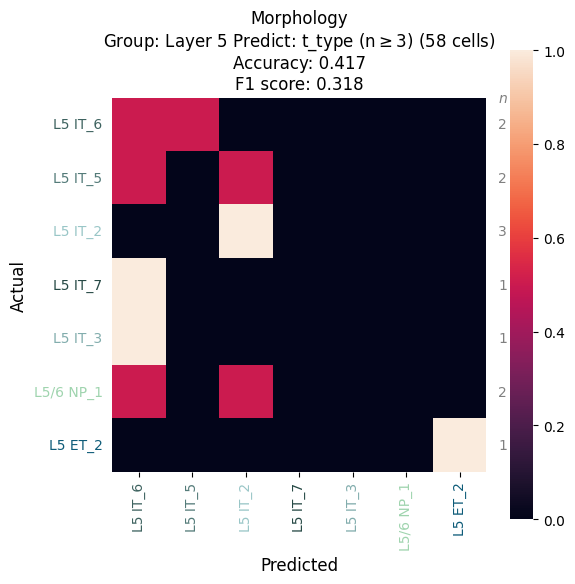

In [31]:
for depth_type in ['withDepth']: #depth_types:

    fig_path = os.path.join(out_dir, 'human_excitatory_morpho_classifier_rf_min_{}_cells_{}_group_{}_{}_removeME.pdf'.format(min_num_cells, feature_type, group_column, depth_type))
    with PdfPages(fig_path) as pdf:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)

        for group in ['Layer 5']: #groups:

            for label_column in ['t_type']: #label_columns:

                # if feature_type == 'rawFeatures':
                data = features_filled[features_filled.index.isin(layer_5_metadata.index)]
                # elif feature_type == 'sparcePCA':
                #     data = features_spca
                # else:
                #     ValueError('feature type not recognized!')

                #select group data and filter out data with a nan label_column value
                this_metadata = layer_5_metadata[layer_5_metadata[group_column] == group].dropna(subset=label_column)

                feature_columns = data.columns.tolist()
                if depth_type == 'withoutDepth':
                    feature_columns.remove('soma_aligned_dist_from_pia')
                    
                id_column = 'specimen_id'
                data = data.merge(this_metadata, how='inner', left_index=True, right_index=True)
                labels = sorted(data[label_column].unique())

                #filter out data in [ttype] with less than n cells
                label_counts = data[label_column].value_counts()
                labels = sorted(label_counts[label_counts >= min_num_cells].index)
                labels = [l for l in label_order[label_column] if l in labels]
                data = data[data[label_column].isin(labels)]
                print(labels)

                #make sure there are at least two label_column values left in data
                if len(this_metadata[this_metadata.index.isin(data.index.tolist())][label_column].unique()) < 2: 
                    print(f"Removing {label_column} gropus with fewer than {min_num_cells} cells left less than 2 types to predict. Skipping this group {group}.")
                    continue

                num_cells_total = len(data)

                #80/20 : train/test
                y = data[label_column]
                X = data[feature_columns]
                X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, data.index, stratify=y, train_size=0.8, random_state=42)  #80/20 : train/test

                #normalize data
                scaler = StandardScaler() 
                X_train = scaler.fit_transform(X_train) 
                X_test = scaler.transform(X_test)

                #stratified kfold cross validation 
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                #make model 
                rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

                # Hyperparameters to search
                param_grid = {
                    'n_estimators': [50, 100, 150],  
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }

                # Perform grid search
                grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, verbose=1, n_jobs=-1)
                grid_search.fit(X_train, y_train)

                # Get the best model
                best_model = grid_search.best_estimator_
                print("Best Parameters:", grid_search.best_params_)

                #test
                y_pred = best_model.predict(X_test)

                #evaluate
                target_names = [l for l in labels if l in sorted(set(y_test))]
                report = classification_report(y_test, y_pred, target_names=target_names)
                accuracy = accuracy_score(y_test, y_pred)
                f1_test = f1_score(y_test, y_pred, average='weighted')
                cm = confusion_matrix(y_test, y_pred, labels=labels)
                true_label_counts = np.sum(cm, axis=1)
                normalized_cm = cm / true_label_counts[:, np.newaxis]

                #PLOT
                fig, ax = plt.subplots(ncols=1, nrows=1, figsize=fig_sizes[group_column])

                formatted_labels = labels # [l[3:].replace('_', ' ') if l.startswith('Exc ') else l.replace('_', ' ') for l in labels]
                sns.heatmap(normalized_cm, annot=False, fmt=".2f", cmap="rocket", vmin=0, vmax=1, xticklabels=formatted_labels, yticklabels=formatted_labels, square=True, cbar=True)

                plt.xlabel('Predicted', fontsize=12)
                plt.ylabel('Actual', fontsize=12)
                plt.title(f'Morphology\nGroup: {group} Predict: {label_column}' + r" (n$\geq${}) ({} cells)".format(min_num_cells, num_cells_total) + '\nAccuracy: ' + str(round(accuracy,3)) + '\nF1 score: ' + str(round(f1_test,3)), fontsize=12)
                plt.xticks(fontsize=10, rotation=90)  
                plt.yticks(fontsize=10, rotation=-0) 

                # Annotating counts on the right side
                for i in range(len(formatted_labels)):
                    ax.text(len(formatted_labels)+num_cell_xbuffer[group_column], i + 0.5 , int(true_label_counts[i]), ha="center", va="center", fontsize=10, color='grey')
                ax.text(len(formatted_labels)+num_cell_xbuffer[group_column], n_height[group_column] , 'n', ha="center", va="center", fontsize=10, color='grey', fontstyle='italic')

                # Removing the axis on the count side
                ax.tick_params(axis='y', which='both', left=False, right=False)

                if 'cluster' in label_column:
                    #plot lines to seperate subclasses
                    for i, l in enumerate(labels):
                        subclass = metadata[metadata[label_column] == l][label_column.replace('cluster', 'subclass')].unique()[0]
                        if i > 0:
                            if last_subclass != subclass:
                                ax.hlines(i, *ax.get_xlim(), color='white', linewidth=1)
                                ax.vlines(i, *ax.get_ylim(), color='white', linewidth=1)
                        last_subclass = subclass

                # Setting different colors for x and y tick labels
                for label in ax.get_xticklabels():  
                    text = label.get_text()
                    # text = '_'.join(text.rsplit(' ', -1))
                    try: 
                        label.set_color(color_dict[text])
                    except: 
                        continue
                for label in ax.get_yticklabels(): 
                    text = label.get_text()
                    # text = '_'.join(text.rsplit(' ', -1)) 
                    try: 
                        label.set_color(color_dict[text])
                    except: 
                        continue

                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.show()
